# Stock Prediction using ARIMA Model

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pandas_datareader as pdr
import yfinance as yf

yf.pdr_override()

## Exploratory Data Analysis

In [2]:
dateparse = lambda dates: pd.to_datetime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('datasets/acgl.us.txt',sep=',', index_col='Date', parse_dates=['Date']).fillna(0)

In [3]:
stock_data

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2005-02-25,13.583,13.693,13.430,13.693,156240,0
2005-02-28,13.697,13.827,13.540,13.827,370509,0
2005-03-01,13.780,13.913,13.720,13.760,224484,0
2005-03-02,13.717,13.823,13.667,13.810,286431,0
2005-03-03,13.783,13.783,13.587,13.630,193824,0
...,...,...,...,...,...,...
2017-11-06,94.490,95.650,94.020,95.550,420192,0
2017-11-07,95.860,95.950,95.200,95.560,464011,0
2017-11-08,95.410,95.900,94.890,95.450,471756,0


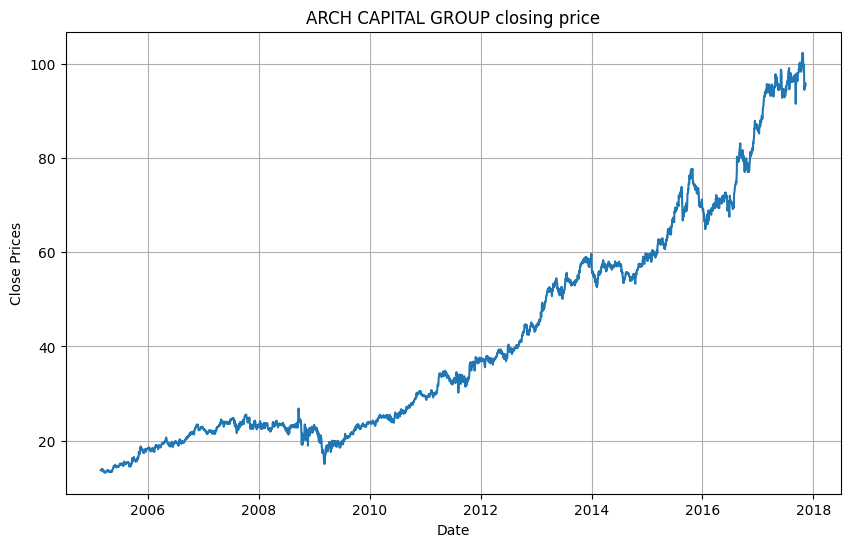

In [4]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<Axes: ylabel='Density'>

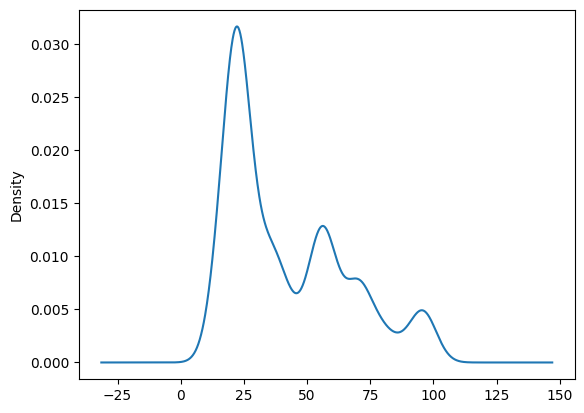

In [5]:
df_close = stock_data['Close']
df_close.plot(kind='kde')

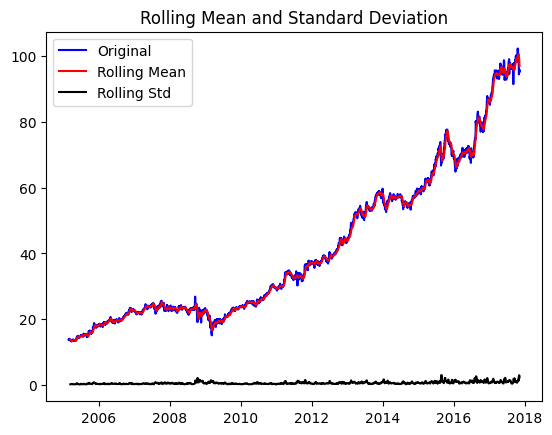

Results of dickey fuller test
Test Statistics                   1.374899
p-value                           0.996997
No. of lags used                  5.000000
Number of observations used    3195.000000
critical value (1%)              -3.432398
critical value (5%)              -2.862445
critical value (10%)             -2.567252
dtype: float64


In [6]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

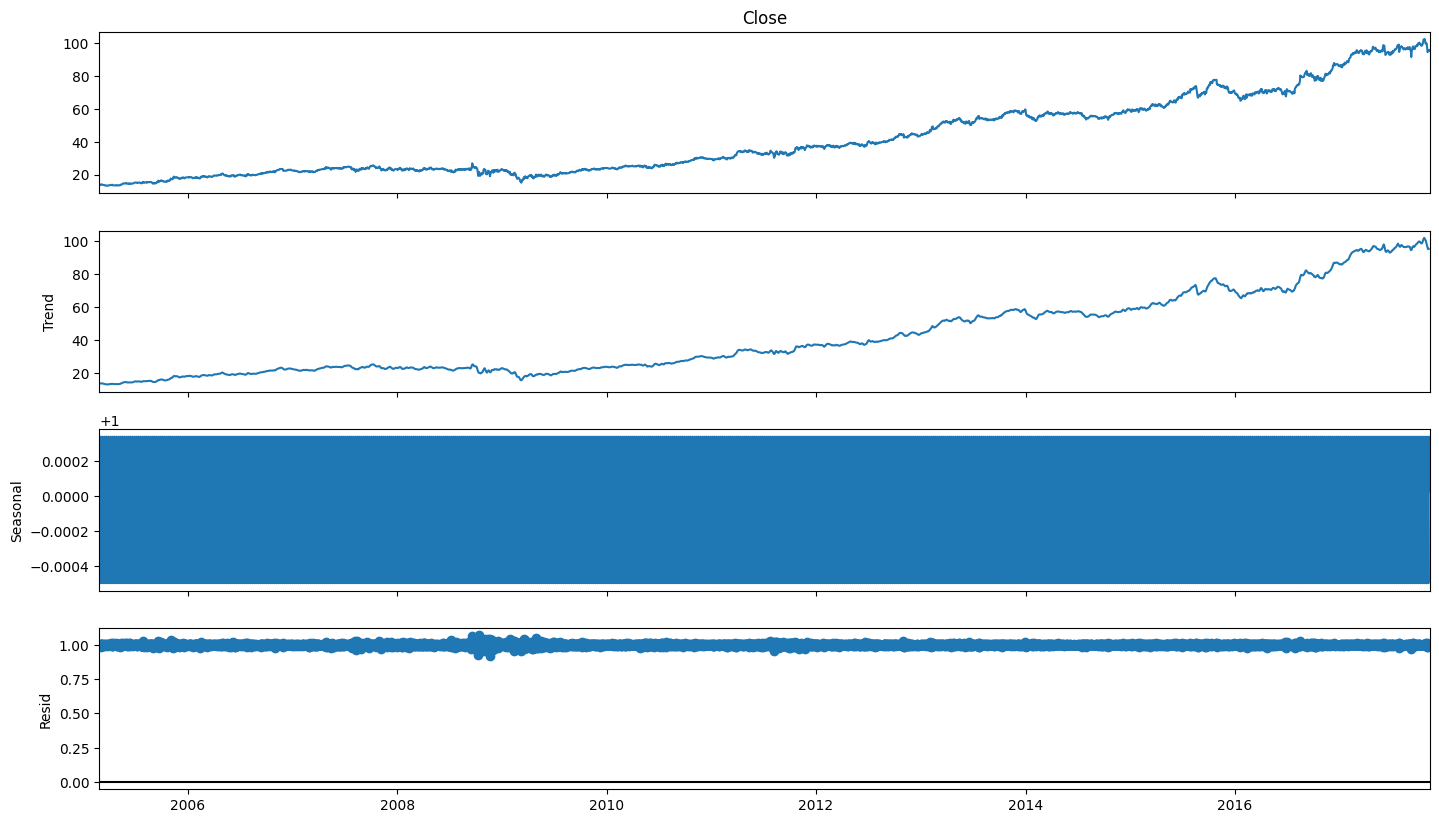

In [7]:
df_close = df_close.asfreq('d').interpolate()
result = seasonal_decompose(df_close, model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


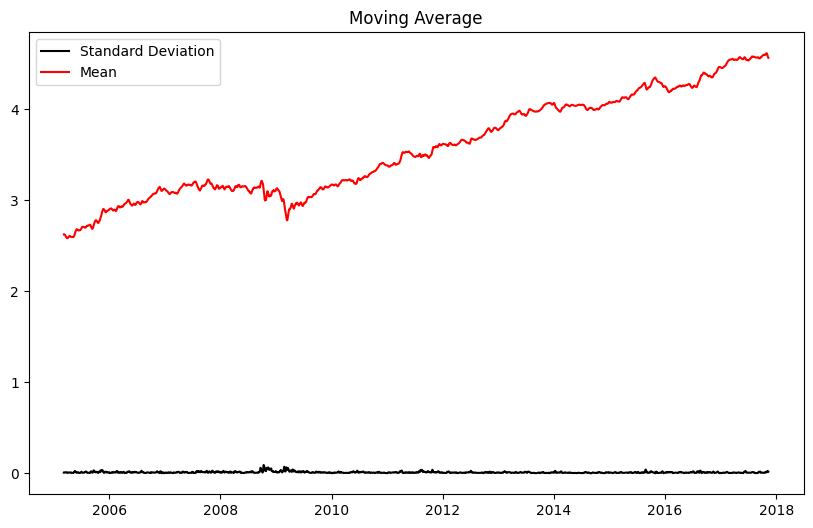

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()


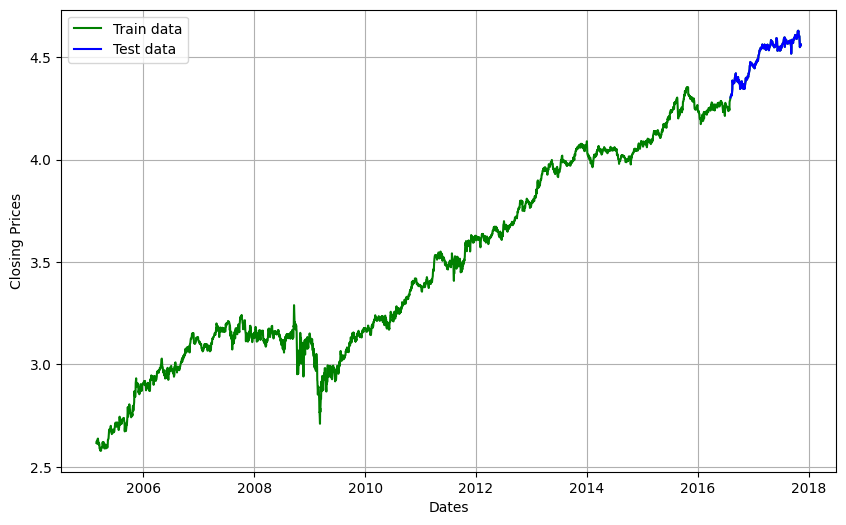

In [9]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


In [10]:
model = ARIMA(train_data, order=(1,2,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4174
Model:                 ARIMA(1, 2, 2)   Log Likelihood               13113.741
Date:                Tue, 15 Aug 2023   AIC                         -26219.482
Time:                        12:53:00   BIC                         -26194.137
Sample:                    02-28-2005   HQIC                        -26210.517
                         - 08-02-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9844      0.008   -119.256      0.000      -1.001      -0.968
ma.L1         -0.0078      0.074     -0.105      0.917      -0.153       0.138
ma.L2         -0.9922      0.074    -13.474      0.0

In [11]:
forecast = fitted.get_forecast(465)  
fc = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)   # 95% conf
fc.index=test_data.index
conf.index=test_data.index

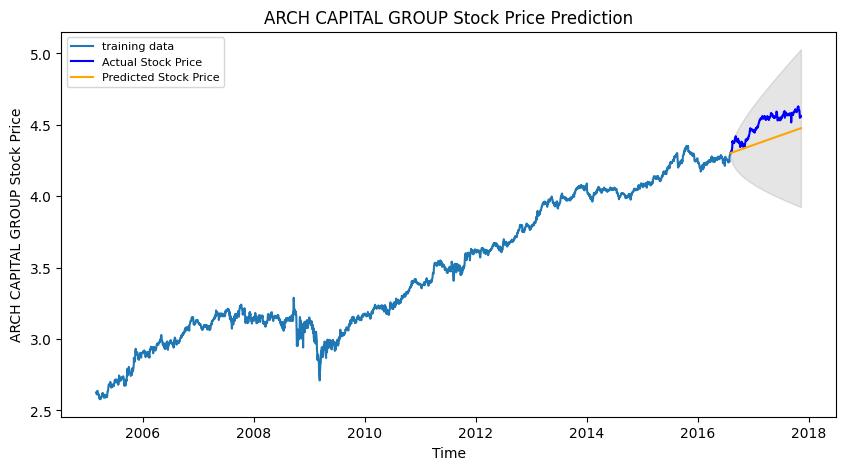

In [12]:
lower_series = pd.Series(conf['lower Close'], index=test_data.index)
upper_series = pd.Series(conf['upper Close'], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()